## Imports

In [76]:
# import numpy as np
import torch
from tqdm.notebook import tqdm
from types import MethodType
import matplotlib.pyplot as plt

In [82]:
import matplotlib
matplotlib.rcParams['figure.facecolor'] = 'white'

In [141]:
%run ../datasets/__init__.py

## Classification

In [131]:
%run ../datasets/cxr14.py

In [185]:
LABELS = CXR14_DISEASES

In [46]:
# Monkey patch the method, to not load images
def getitem_labelsonly(self, idx):
    row = self.label_index.iloc[idx]
    labels = row[self.labels].to_numpy().astype('int')
    
    return BatchItem(labels=labels)

CXR14Dataset.__getitem__ = getitem_labelsonly

In [183]:
def compute_average_balance(**kwargs):
    dataloader = prepare_data_classification(**kwargs)

    n_batches = len(dataloader)
    n_labels = len(dataloader.dataset.labels)

    positives_by_label = []

    for batch in tqdm(iter(dataloader)):
        labels = batch.labels.sum(dim=0) # shape: n_labels

        empty_count = batch.labels.sum(dim=1) # shape: n_batches
        empty_count = (empty_count == 0).sum().unsqueeze(0) # shape: 1
        empty_count = empty_count.type(labels.dtype)
        
        labels = torch.cat((labels, empty_count), dim=0) # shape: n_labels+1
        
        positives_by_label.append(labels)

    positives_by_label = torch.stack(positives_by_label, dim=0)
    # shape: n_batches, n_labels+1

    print('Amount of positives by label, in average: ', positives_by_label.float().mean(dim=0))
    print('Batch size: ', dataloader.batch_size)

    return positives_by_label

In [187]:
def plot_distributions(dist, batch_size, n_rows=3, n_cols=5, bins=10):
    plt.figure(figsize=(15, 10))
    
    labels = list(LABELS) + ['None']
    
    plt.suptitle(f'BS={batch_size}, SAMPLER={str(dataloader.sampler.__class__)}')
    
    dist = dist.float()

    for i_label, label_name in enumerate(labels):
        plt.subplot(n_rows, n_cols, i_label + 1)
        
        arr = dist[:, i_label]
        mean_value = arr.mean()

        vals, _, _ = plt.hist(arr, bins=bins)
        plt.vlines(mean_value, 0, vals.max(), color='red')
        plt.title(f'{label_name}, {mean_value:.1f}, {mean_value/batch_size*100:.1f}%')

In [65]:
CXR_14_KWARGS = {
    'dataset_name': 'cxr14',
    'dataset_type': 'train',
}

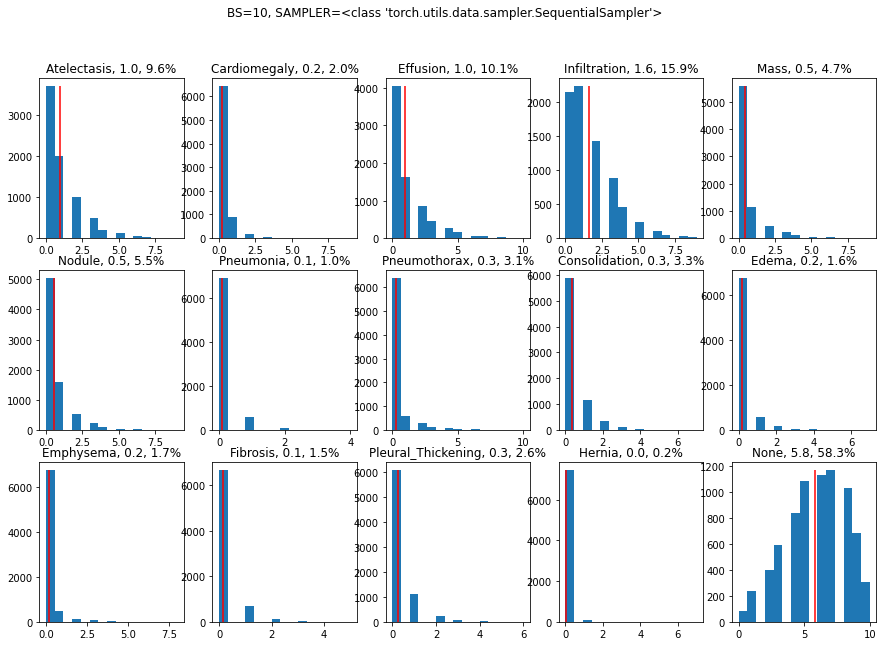

In [188]:
# dist_10 = compute_average_balance(batch_size=10, **CXR_14_KWARGS)
plot_distributions(dist_10, 10, bins=15)

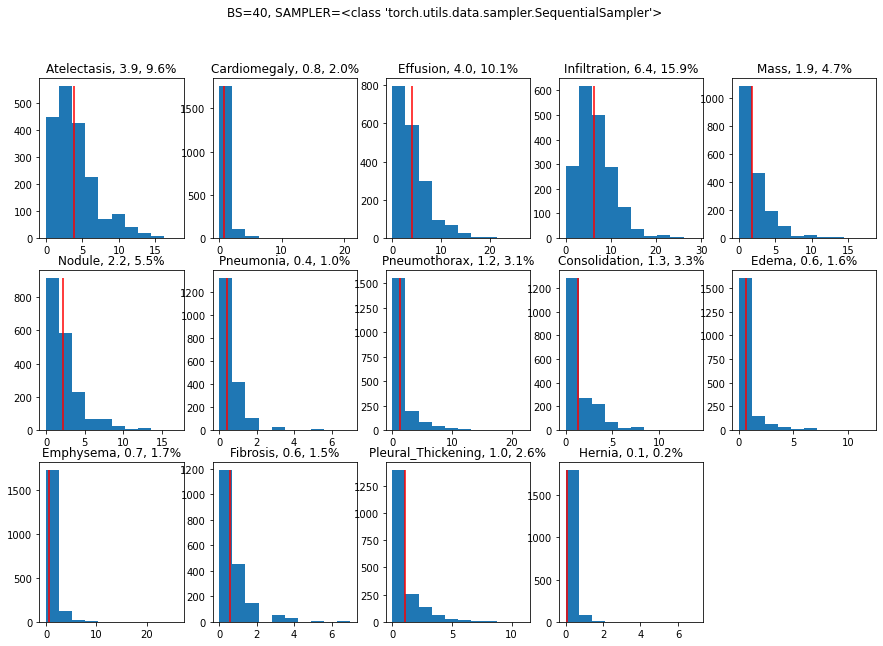

In [137]:
# dist_40 = compute_average_balance(batch_size=40, **CXR_14_KWARGS)
plot_distributions(dist_40, 40)

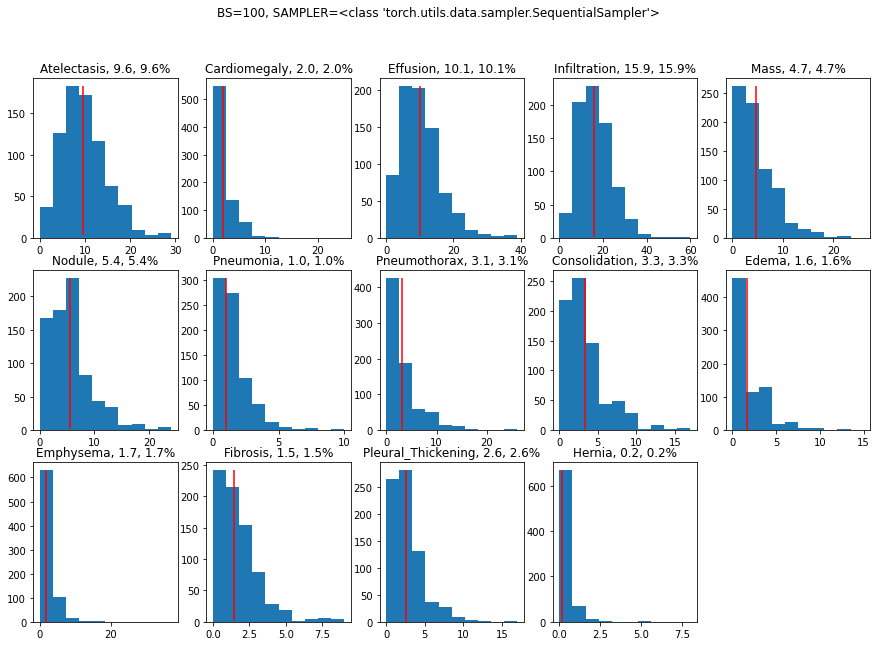

In [138]:
# dist_100 = compute_average_balance(batch_size=100, **CXR_14_KWARGS)
plot_distributions(dist_100, 100)

Loading cxr14/train dataset...
	Oversampling Atelectasis: os-class=1 ratio=9 positives=7306 negatives=68408 new-total=134162 original=75714



Amount of positives by label, in average:  tensor([19.5988,  0.8352,  6.7162,  8.0271,  2.1040,  2.1159,  0.5967,  1.5246,
         2.3347,  0.6754,  0.9639,  0.7210,  1.2790,  0.1043])
Batch size:  40


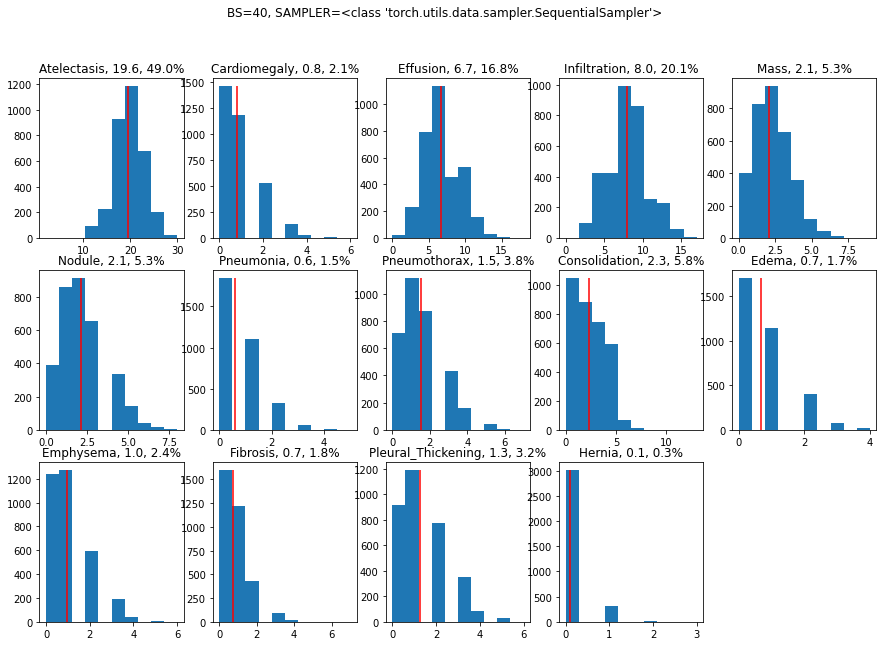

In [139]:
bs = 40
dist_40_os = compute_average_balance(batch_size=bs, oversample=True, **CXR_14_KWARGS)
plot_distributions(dist_40_os, bs)

Loading cxr14/train dataset...
	Oversampling Cardiomegaly: os-class=1 ratio=49 positives=1490 negatives=74224 new-total=147234 original=75714



Amount of positives by label, in average:  tensor([ 4.1233, 19.8343,  9.1163,  6.5143,  1.6895,  1.8655,  0.4026,  0.8745,
         1.4238,  0.9829,  0.6808,  0.6398,  1.3613,  0.0994])
Batch size:  40


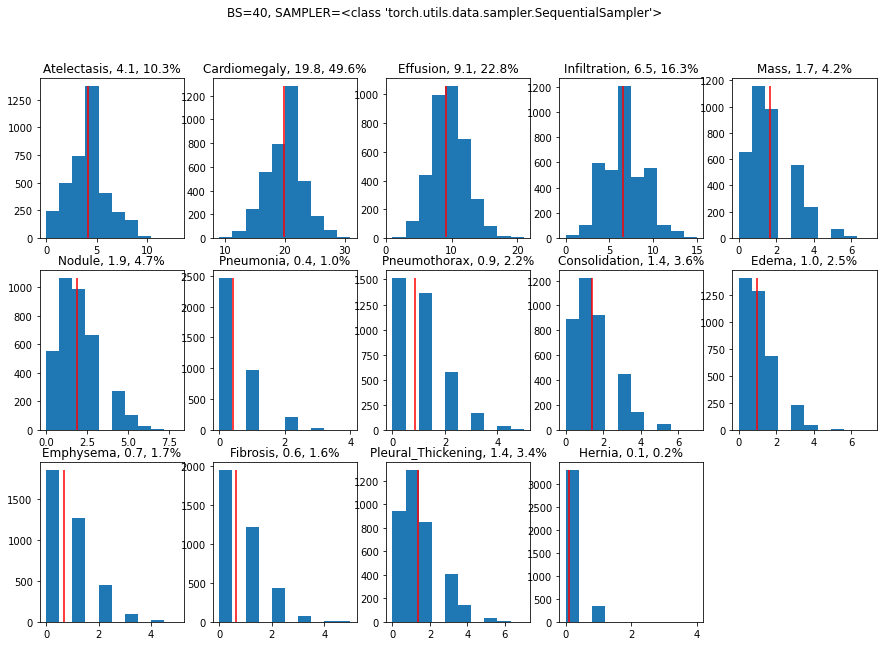

In [140]:
bs = 40
dist = compute_average_balance(batch_size=bs,
                                     oversample=True,
                                     oversample_label=1,
                                     **CXR_14_KWARGS)
plot_distributions(dist, bs)

## Report generation

In [189]:
def getitem_labelsonly(self, idx):
    report = self.reports[idx]
    filename = report['filename']
    labels = self.labels_by_report[filename]
    
    return BatchItem(labels=labels, report=report['tokens_idxs'])

IUXRayDataset.__getitem__ = getitem_labelsonly

In [190]:
%run ../datasets/common.py

In [191]:
shorter_label = {
    'No Finding': 'NF',
    'Enlarged Cardiomediastinum': 'Enl Card',
    'Pleural Effusion': 'Pleural-E',
    'Pleural Other': 'Pleural-O',
    'Support Devices': 'Dev',
}

LABELS = [
    shorter_label.get(l, l)
    for l in CHEXPERT_LABELS
]

In [192]:
IU_KWARGS = {
    'dataset_name': 'iu-x-ray',
    'dataset_type': 'train',
}

Loading iu-x-ray/train dataset...



Amount of positives by label, in average:  tensor([15.9262,  1.7852,  6.0134,  1.6309,  6.8658,  0.2685,  0.5839,  0.3624,
         1.9933,  0.4027,  1.2282,  0.3893,  1.1477,  2.3087,  7.9060])
Batch size:  40


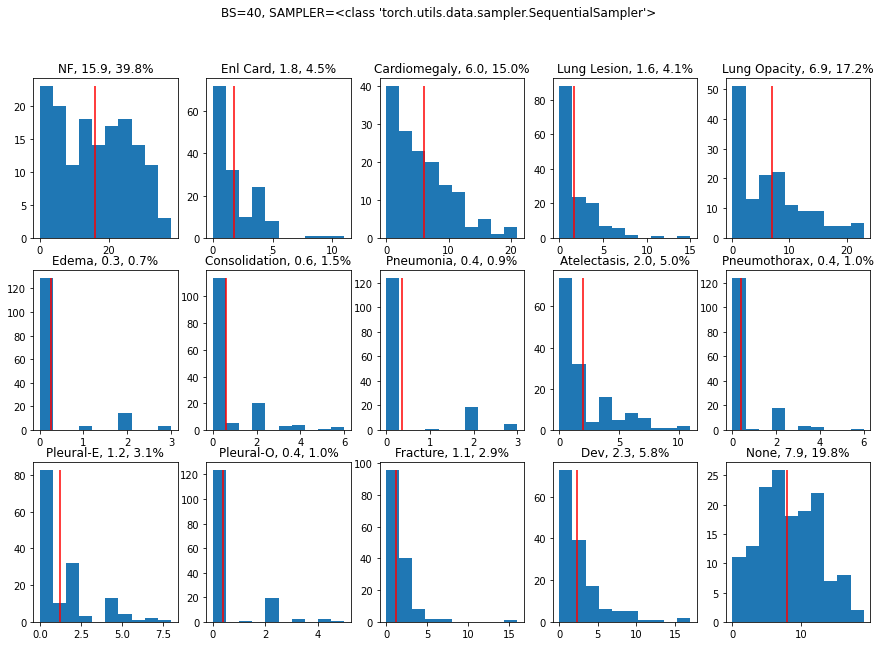

In [193]:
bs = 40
dist = compute_average_balance(batch_size=bs, **IU_KWARGS)
plot_distributions(dist, bs)